In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf

from models import network, model_utils, inception_v1


os.sys.path.append("C:\\Users\\Tom\\Workspace\\KeywordSearch\\tensorflow")

In [2]:
folder = "C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img"
filenames = [os.path.join(folder, f) for f in os.listdir(folder)]

In [3]:
def grad_cam(output, grad):
    weights = np.mean(grad, axis=(0,1))
    
    grad_cam = np.ones(output.shape[0:2], dtype=np.float32)

    # weighted average
    for i, w in enumerate(weights):
        grad_cam += w * output[:, :, i]

#     print(grad_cam)
    
    # pass through relu
    grad_cam = np.maximum(grad_cam, 0)

    # resize heatmap to be the same size as the input
#     if should_resize:
#         grad_cam = grad_cam / np.max(grad_cam) # values need to be [0,1] to be resized
#         with self.graph.as_default():
#             grad_cam = np.squeeze(tf.image.resize_bilinear(
#                 np.expand_dims(np.expand_dims(grad_cam, 0), 3), 
#                 x_value.shape[:2]).eval(session=self.session))

    # convert grayscale to 3-D
#     if three_dims:
#         grad_cam = np.expand_dims(grad_cam, axis=2)
#         grad_cam = np.tile(grad_cam,[1,1,3])

    return grad_cam

def print_grad_cam(filename, grad_cam, probability, image):
    print(filename)
    
    top_prob = np.argsort(probability)[::-1][:5]
#     print(top_prob)
#     print(probability[top_prob])
    
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(dpi=180)
    fig.add_subplot(131)
    plt.imshow(grad_cam ,cmap=plt.cm.gray, vmin=0, vmax=1)
    fig.add_subplot(132)
    plt.imshow(cam_heatmap)
    fig.add_subplot(133)
    plt.imshow(image, vmin=-1, vmax=1)
    
    plt.show()

INFO:tensorflow:Restoring parameters from C:\Users\Tom\Workspace\KeywordSearch\tensorflow\bin\checkpoints\model_v1.ckpt-280000
>> Classification started with neuron 694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_051009_000.jpg'


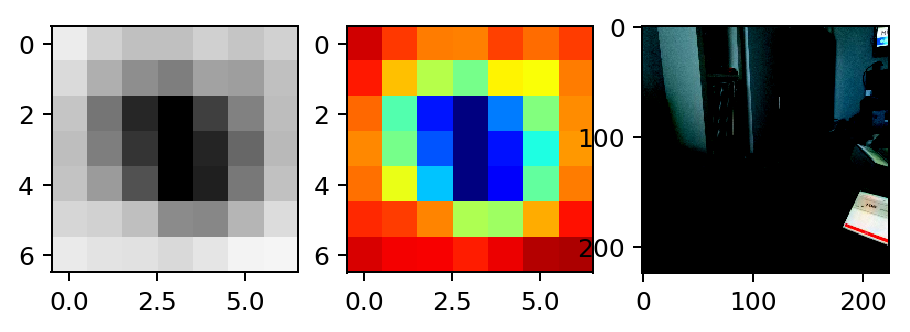

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_051713_000.jpg'


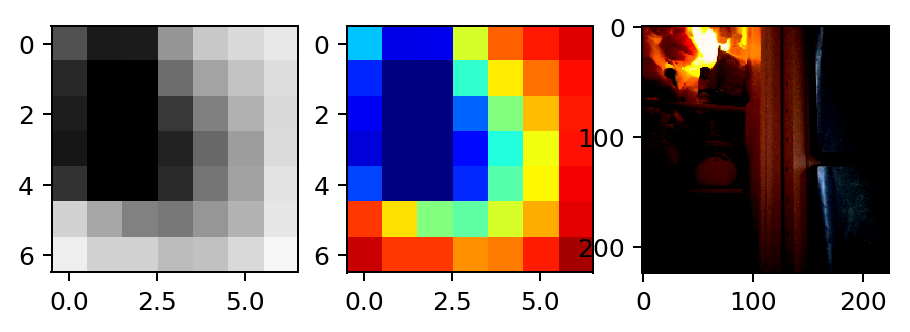

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_051847_000.jpg'


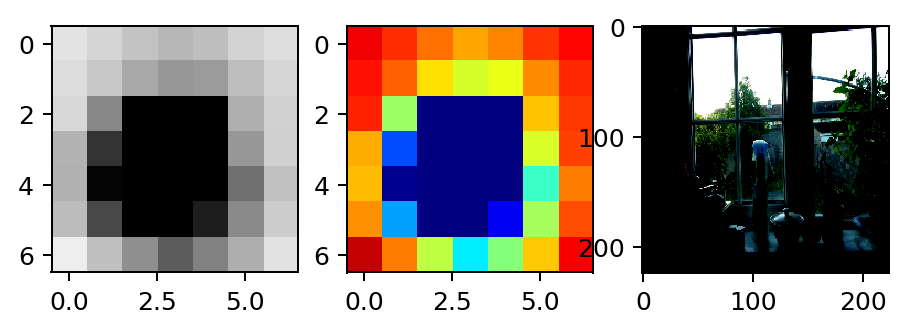

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_052108_000.jpg'


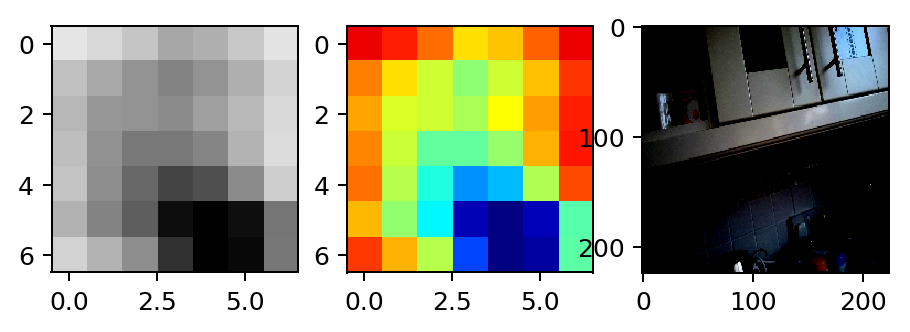

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_053132_000.jpg'


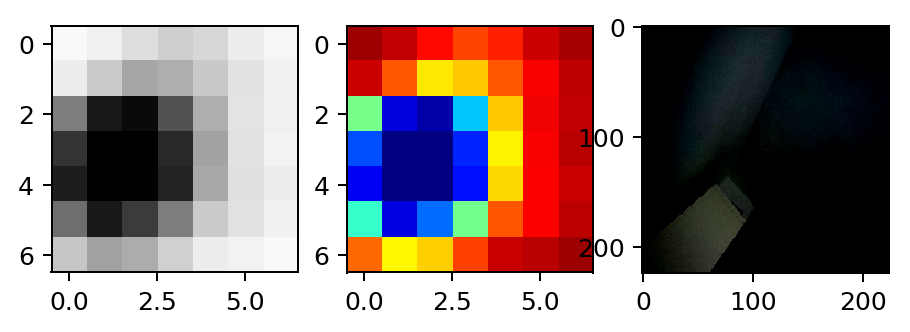

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_053219_000.jpg'


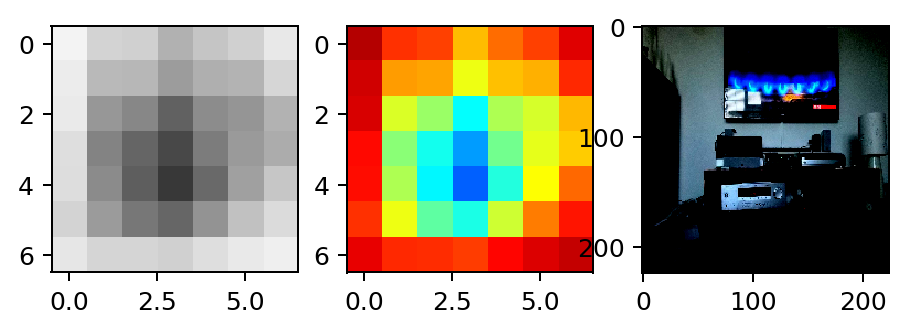

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_053927_000.jpg'


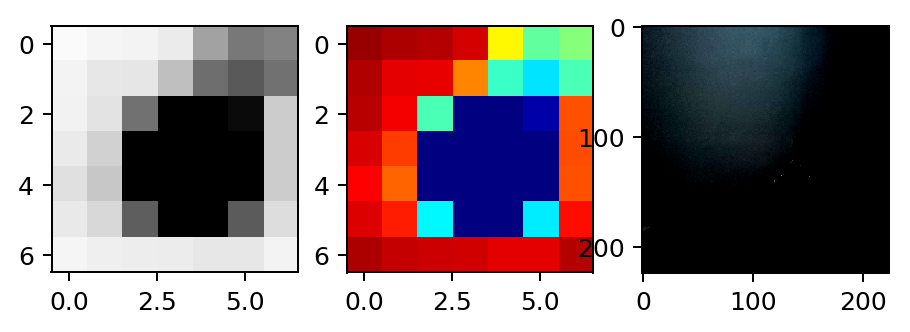

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_054729_000.jpg'


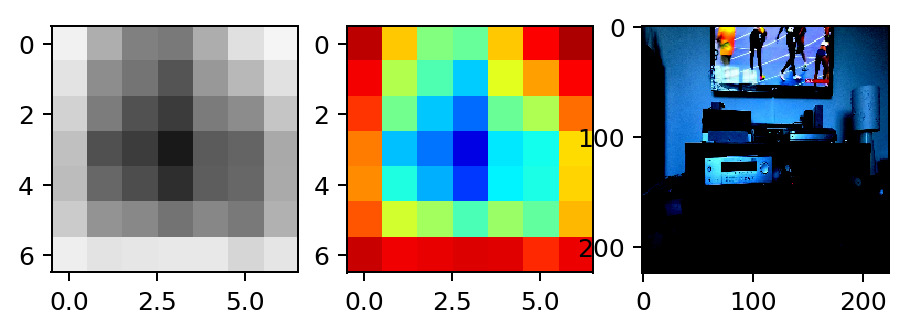

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_055519_000.jpg'


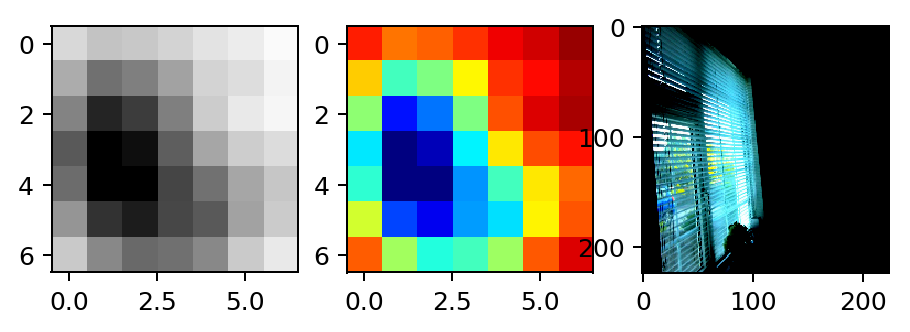

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_061334_000.jpg'


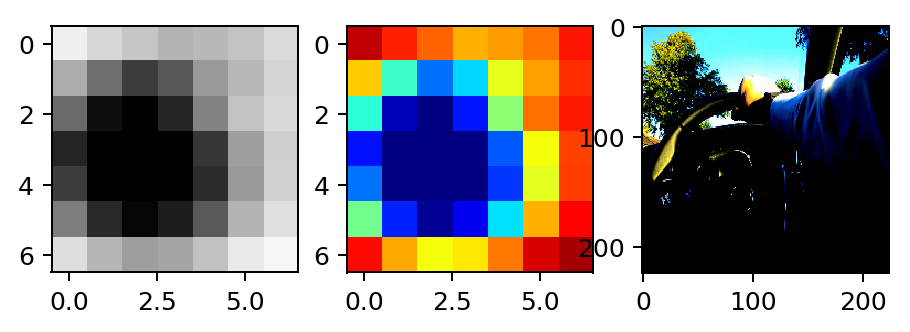

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_062124_000.jpg'


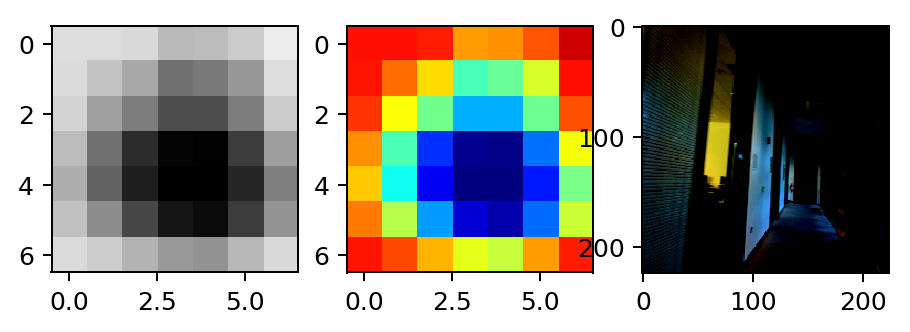

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_062927_000.jpg'


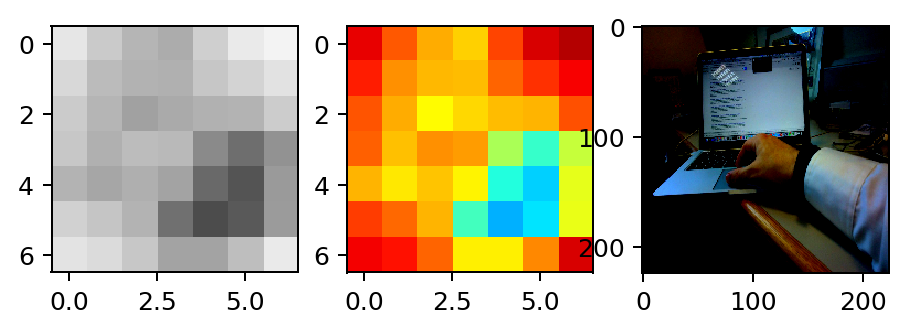

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


b'C:\\Users\\Tom\\Workspace\\KeywordSearch\\edges\\img\\20160815_064508_000.jpg'


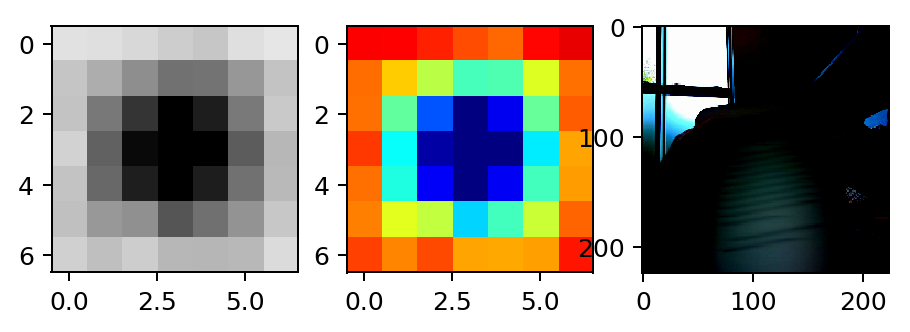

>> Classification completed.


In [4]:
# mobile phone: 654
keys, images = network.get_image_as_batch(filenames, inception_v1.default_image_size, batch_size=1)

session = tf.Session()
session.run(tf.local_variables_initializer())

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=session, coord=coord)

logits, end_points = network.build_net(images, 1390, scope='InceptionGeneralist', is_training=False)


inception_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='InceptionV1')
generalist_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='InceptionGeneralist')

probabilities = tf.nn.softmax(logits, name='Probability')

neuron_selector = tf.placeholder(tf.int32)

target_neuron = logits[0][neuron_selector]
conv_layer = end_points["Mixed_5c"]
grads = tf.gradients(target_neuron, conv_layer)[0]

session.run(tf.global_variables_initializer())

model_utils.restore_model(session, "C:\\Users\\Tom\\Workspace\\KeywordSearch\\tensorflow\\bin", None)

selected_neuron = 694 #888 - computer; 696 - screen; 694 - keyboard; 692 - mouse; 960 - computer

print(">> Classification started with neuron " + str(selected_neuron))

try:
    while not coord.should_stop():
        r_keys, r_prob, r_conv, r_grads, r_images = session.run([keys, probabilities, conv_layer, grads, images],
                                                                feed_dict={neuron_selector: selected_neuron})
        
        r_grad_cam = grad_cam(r_conv[0], r_grads[0])
        print_grad_cam(r_keys[0], r_grad_cam, r_prob[0], r_images[0])
    
        for a in range(len(r_keys)):
            _, filename = os.path.split(r_keys[a])
            if isinstance(filenames, dict):
                file_id = filenames[r_keys[a].decode("utf-8")]
            else:
                file_id = int(filename[:-4])

            r_top_indexes = np.where(r_prob[a] >= 0.001)[0]
            m_len = len(r_top_indexes)
            r_top_vals = np.zeros(m_len)

            for b in range(m_len):
                r_top_vals[b] = r_prob[a][r_top_indexes[b]]
                
except tf.errors.OutOfRangeError:
    print(">> Classification completed.")
finally:
    # When done, ask the threads to stop.
    coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    session.close()
